## Import libraries

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as Fun
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook
from My_ViT import VisionTransformer, img_to_patch


In [2]:
model = torch.load('./saved_model.pth')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print("Device:", device)
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: mps


/var/folders/4t/vzt8rmpj2bzg8tyypgszxpqc0000gp/T/ipykernel_52307/1183298594.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./saved_model.pth')


In [3]:
image_size = 28
embed_dim=255
hidden_dim=embed_dim*3
num_heads=3
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

## Downloading FashionMNIST from torchvision

In [4]:
# Apply random transformations

def random_transform(image):
  if random.random() < 0.5:  # 50% prob of applying a transformation
    if random.random() < 0.5:  # 50% prob of rotation
      angle = random.choice([0, 90, 180, 270])
      image = Fun.rotate(image, angle)
    else:  # otherwise translation
      translate = (random.uniform(0, 0.1), random.uniform(0, 0.1))
      image = Fun.affine(image, angle=0, translate=translate, scale=1, shear=0)
  return image

# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([
  T.Lambda(random_transform), #apply random transformation
  T.ToTensor(),
  T.Normalize((0.5,), (0.5,))
  ])


# download fashionMNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download fashionMNIST test set
test_set = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

## Picking one test sample and running it through the attention block

In [15]:
test_sample_index = (test_set.targets==8).nonzero(as_tuple=True)[0][13].item()
print(test_sample_index)
#img_tensor = test_set.data[test_sample_index].to(device)
img_original = test_set[test_sample_index][0].squeeze().to(device)
img_tensor = (img_original * 255).clamp(0, 255).byte()
print(img_tensor.dtype)
patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
patches = model.input_layer(patches.float())
transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding

116
torch.uint8


## Plotting attention


In [16]:
# Funzione per il rollout dell'attenzione
def attention_rollout_function(attn_maps):
    attn_rollout = []
    I = torch.eye(attn_maps[0].shape[-1]).to(attn_maps[0].device)  # Matrice identità sulla corretta device
    prod = I
    for i, attn_map in enumerate(attn_maps):
        # Somma dell'attenzione con la matrice identità (residual connection)
        prod = prod @ (attn_map + I)  
        
        # Normalizzazione
        prod = prod / prod.sum(dim=-1, keepdim=True) 
        attn_rollout.append(prod)
    return attn_rollout

In [17]:
# Funzione per estrarre le matrici di attenzione attraverso i livelli del vit
def extract_attention_maps(model, transformer_input, num_heads, device):
    attn_maps = []

    for block in model.transformer:
        
        # Estrai il tensore linearizzato del blocco
        transformer_input_expanded = block.linear[0](transformer_input).squeeze(0)
        
        # Reshape del risultato dell'attenzione
        qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
        q = qkv[0]  # Matrice delle query (num_heads, num_patches + 1, embedding_size // num_heads)
        k = qkv[1]  # Matrice delle key (num_heads, num_patches + 1, embedding_size // num_heads)
        
        # Moltiplicazione di q e k^T per ottenere le matrici di attenzione per ciascuna head
        kT = k.transpose(-2, -1)  # Trasposizione per la moltiplicazione corretta
        attention_matrices = torch.matmul(q, kT)  # Dim: (num_heads, num_patches + 1, num_patches + 1)
       

        # Aggiunta delle connessioni residue e normalizzazione
        residual_att = torch.eye(attention_matrices.size(-1)).to(device)
        aug_att_mats = attention_matrices + residual_att
        aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)

        # Media su tutte le teste di attenzione
        avg_attention = aug_att_mats.mean(dim=0)  # Media delle heads

        # Aggiungi la matrice di attenzione alla lista
        attn_maps.append(avg_attention)

    return attn_maps

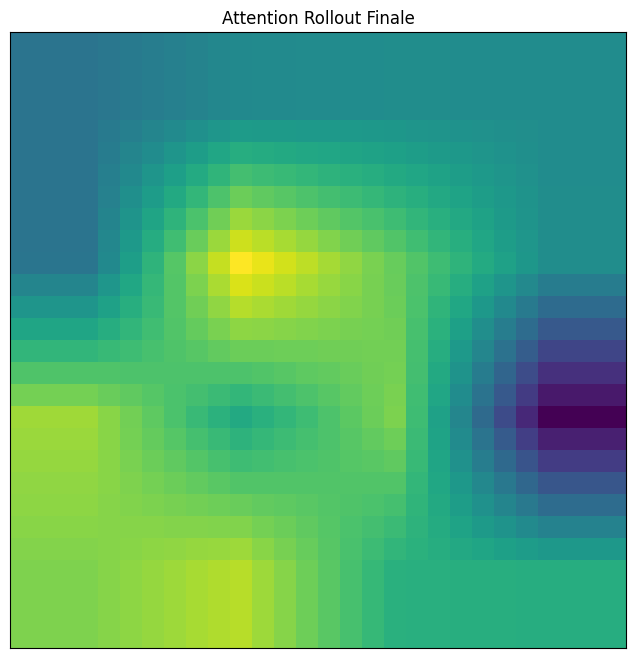

In [18]:
# Estrai le mappe di attenzione
attn_maps = extract_attention_maps(model, transformer_input, num_heads, device)

# Esegui il rollout sulle mappe di attenzione estratte
rollout_matrices = attention_rollout_function(attn_maps)

# Visualizza il risultato del rollout finale
final_rollout = rollout_matrices[-1]  # La matrice finale dopo il rollout di tutti i livelli

# Visualizzazione delle heatmap dell'attenzione rollout finale
fig, ax = plt.subplots(figsize=(8, 8))
attn_heatmap = final_rollout[0, 1:].reshape((int(image_size / patch_size), int(image_size / patch_size)))
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
ax.imshow(attn_heatmap_resized.detach().cpu().numpy(), cmap='viridis')
ax.set_title('Attention Rollout Finale')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

plt.show()

attn_heatmap:  torch.Size([4, 4])
attn_heatmap_resized:  torch.Size([28, 28, 1])


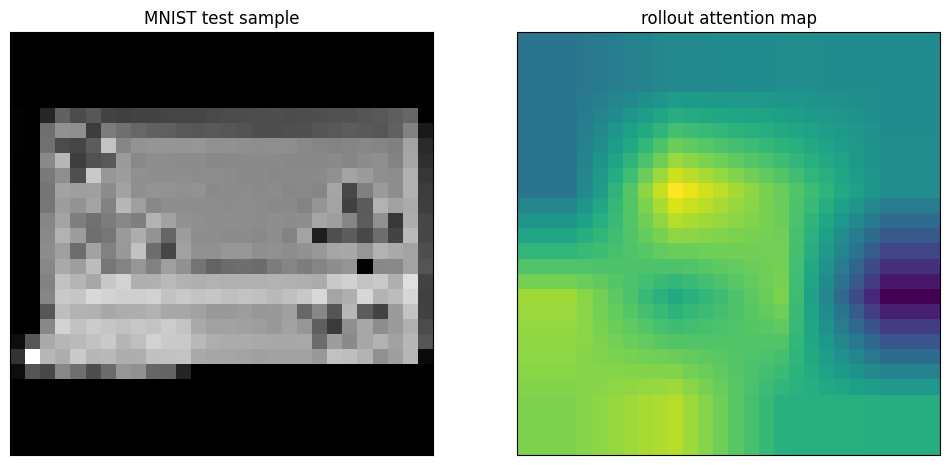

In [21]:
attn_heatmap = final_rollout[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
print("attn_heatmap: ", attn_heatmap.shape)
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
print("attn_heatmap_resized: ", attn_heatmap_resized.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img = np.asarray(img_original.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.imshow(attn_heatmap_resized.detach().cpu().numpy())
ax2.set_title('rollout attention map')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)